In [1]:
#required libraries and settings
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yaml
import io
import math

import BMILorenz

In [2]:
#settings

J = 40 #dimension of Lorenz Model
observationSigma = 1.0 #standard deviation of the observations


In [3]:
#initialize the model
J = 40 #dimension of Lorenz Model

#make a starting state vector
commonStartState = np.zeros(J)
commonStartState[19]=0.01

# Define settings data
settings = {'J': J,
            'F': 8.0,
            'startTime': 0.0,
            'endTime': 20.0,
            'dt':1e-3,
            'startState': commonStartState}

# Write YAML file
with io.open('settings.yaml', 'w', encoding='utf8') as outfile:
    yaml.dump(settings, outfile, default_flow_style=False, allow_unicode=True)

In [4]:
N = 25 #numeber of ensemble members

p = 0.80
#start with  an empty ensemble
ensemble = []


#create and initialize an instance of the BMILorenz class
truthModel = BMILorenz.BMILorenz ()
truthModel.initialize('settings.yaml')

output = pd.DataFrame(columns = ['truth','observation'])

for n in range (N):
    #add an ensemble methods
    ensemble.append(BMILorenz.BMILorenz ())
    ensemble[n].initialize('settings.yaml')
    ensemble[n].set_value_at_indices('state',5,ensemble[n].get_value_at_indices('state',5) + np.random.randn(1)*0.01)
    
    #also add a column to the output dataframe to store the output
    output['ensemble' + str(n)]= np.nan
    
 

In [37]:
def H(state):
    return state

def EnKF(ensembleForecast, observationEnsemble, transformation):
    #use notation from Evenson 2003.
    A=ensembleForecast
    D=observationEnsemble
    H=transformation
    N=np.shape(A)[1]

    Apr = A @ (np.eye(N)-(1/N)*np.ones(N))
    Dpr = D - H(A)
    gamma=D @ (np.eye(N)-(1/N)*np.ones(N))


    #now calculate [U,S,V]=SVD(H*Apr+gamma)
    Utemp,Sigma,vH = np.linalg.svd(H(Apr)+gamma)
    #only keep p % of singular values, discard minimum of 1.
    pN = max(1, math.floor(N * (1-p)))

    U=np.zeros([np.shape(D)[0],N])

    U[0:(np.shape(Utemp)[0]),0:min((np.shape(Utemp)[1]-pN-1),np.shape(U)[1]-pN-1)]=Utemp[:,0:min((np.shape(Utemp)[1]-pN-1),np.shape(U)[1]-pN-1)]

    Sigma=np.diag(Sigma) @ np.diag(Sigma).T
    Sigma = np.power(np.diag(Sigma),-1)
    Sigma[-pN:] = 0
    LambdaInv = np.zeros([N,N])
    LambdaInv[0:np.shape(Sigma)[0],0:np.shape(Sigma)[0]]=np.diag(Sigma)

    X1=LambdaInv @ U.T
    X2=X1 @ Dpr
    X3=U @ X2
    X4=H(Apr).T @ X3
    ensembleAnalyses = A + Apr @ X4
    return ensembleAnalyses

In [6]:
#spin up the Ensemble. 

while truthModel.get_current_time()< 3.0:
    
    truthModel.update()
    output.loc[truthModel.get_current_time()] = truthModel.get_value_at_indices('state',5)
    
    observation = truthModel.get_value('state') + observationSigma * np.random.randn(J)

    #loop through the ensemble members and store the state after each update
    for n in range (N):
        ensemble[n].update()
        output.at[ensemble[n].get_current_time(),'ensemble' + str(n)] = ensemble[n].get_value_at_indices('state',5)
        
    #TODO update observation on bases of observation
    
    #TODO track statistics metrics


In [21]:
#run 

foreCastEnsemble = np.zeros([J,N])
observationEnsemble = np.zeros([J,N])

while truthModel.get_current_time()<truthModel.get_end_time():
#for n in range (1):
    truthModel.update()
    output.loc[truthModel.get_current_time()] = truthModel.get_value_at_indices('state',5)
    
    observation = truthModel.get_value('state') + observationSigma * 0.1 * np.random.randn(J)
    
    

    #loop through the ensemble members and store the state after each update
    for n in range (N):
        ensemble[n].update()
        foreCastEnsemble[:,n] = ensemble[n].get_value('state')
        observationEnsemble[:,n] = observation + np.random.randn(J)
        output.at[ensemble[n].get_current_time(),'ensemble' + str(n)] = ensemble[n].get_value_at_indices('state',5)
        
    #TODO update ensemble on bases of observation
    analysesEnsemble = EnKF(foreCastEnsemble,observationEnsemble,H)
    
    for n in range (N):
        ensemble[n].set_value('state',analysesEnsemble[:,n])
    
    
    #TODO track statistics metrics


/Users/rwhut/Documents/eWaterCycle/repos/streamingDataAssimilation/BMILorenz.py:28: RuntimeWarning: overflow encountered in double_scalars
  k[j] =(state[j+1] - state[j-2])*state[j-1] - state[j]
/Users/rwhut/Documents/eWaterCycle/repos/streamingDataAssimilation/BMILorenz.py:24: RuntimeWarning: overflow encountered in double_scalars
  k[1] = (state[2] - state[J-1])*state[0] - state[1]
/Users/rwhut/Documents/eWaterCycle/repos/streamingDataAssimilation/BMILorenz.py:28: RuntimeWarning: invalid value encountered in double_scalars
  k[j] =(state[j+1] - state[j-2])*state[j-1] - state[j]
/Users/rwhut/Documents/eWaterCycle/repos/streamingDataAssimilation/BMILorenz.py:23: RuntimeWarning: invalid value encountered in double_scalars
  k[0] = (state[1]-state[J-2]) * state[J-1] - state[0]
/Users/rwhut/Documents/eWaterCycle/repos/streamingDataAssimilation/BMILorenz.py:24: RuntimeWarning: invalid value encountered in double_scalars
  k[1] = (state[2] - state[J-1])*state[0] - state[1]
/Users/rwhut/Docu

LinAlgError: SVD did not converge

In [23]:
np.amax(analysesEnsemble)

1.3869125648563302e+117

In [29]:
truthModel.get_current_time()

3.0279999999997775

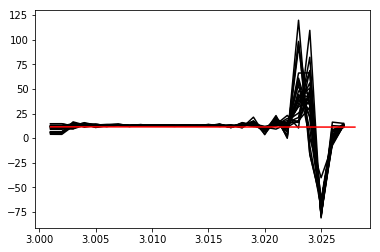

In [28]:
plt.plot(output.loc[3:3.06,'ensemble0':],'k')
plt.plot(output.loc[3:3.06,'truth'],'r')
plt.show()

In [25]:
A=foreCastEnsemble
D=observationEnsemble

N=np.shape(A)[1]


Apr = A @ (np.eye(N)-(1/N)*np.ones(N))
Dpr = D - H(A)
gamma=D @ (np.eye(N)-(1/N)*np.ones(N))


#now calculate [U,S,V]=SVD(H*Apr+gamma)
Utemp,Sigma,vH = np.linalg.svd(H(Apr)+gamma)
#only keep p % of singular values, discard minimum of 1.
pN = max(1, math.floor(N * (1-p)))

U=np.zeros([np.shape(D)[0],N])

U[0:(np.shape(Utemp)[0]),0:min((np.shape(Utemp)[1]-pN-1),np.shape(U)[1]-pN-1)]=Utemp[:,0:min((np.shape(Utemp)[1]-pN-1),np.shape(U)[1]-pN-1)]

Sigma=np.diag(Sigma) @ np.diag(Sigma).T
Sigma = np.power(np.diag(Sigma),-1)
Sigma[-pN:] = 0
LambdaInv = np.zeros([N,N])
LambdaInv[0:np.shape(Sigma)[0],0:np.shape(Sigma)[0]]=np.diag(Sigma)

X1=LambdaInv @ U.T
X2=X1 @ Dpr
X3=U @ X2
X4=H(Apr).T @ X3
ensembleAnalyses = A + Apr @ X4

LinAlgError: SVD did not converge

In [ ]:
Sigma[-pN:] = 0

In [ ]:
Sigma

In [ ]:
np.max(ensembleAnalyses)

In [30]:
A=np.random.randn(5,5)

In [31]:
A

array([[-1.61343937, -0.00392679, -0.88113593,  1.76802718,  0.01448352],
       [-0.33520859,  0.58024134, -0.133738  ,  1.62088735,  0.0646234 ],
       [-0.41964762, -1.94815787,  0.34537731,  0.00652228, -0.96228223],
       [-0.47851927, -0.12225665,  1.44204906,  0.56163556, -0.58225079],
       [ 0.34438242,  0.60348866, -0.65518083, -0.49910903,  1.58763086]])

In [36]:
foreCastEnsemble.shape

(40, 25)

In [34]:
np.cov(A)

array([[ 1.60080092,  0.94510248, -0.01211886,  0.15099284, -0.1605908 ],
       [ 0.94510248,  0.61317016, -0.00432286,  0.11860427, -0.2201009 ],
       [-0.01211886, -0.00432286,  0.81070435,  0.4974508 , -0.56369936],
       [ 0.15099284,  0.11860427,  0.4974508 ,  0.71079687, -0.65369856],
       [-0.1605908 , -0.2201009 , -0.56369936, -0.65369856,  0.82504799]])